In [27]:
import re
import json
from functools import partial
from multiprocessing import Pool
from pathlib import Path
from collections.abc import Iterable

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
SEED_TO_SETTING = {
    9545076: 2,
    8433255: 1,
    7283613: 1,
    5463433: 2,
    4932797: 2,
    2724542: 1,
    1403899: 1,
    1116077: 2,
    445741: 2,
    81708: 1
}

In [40]:
TABLE_CONVERSIONS = {
}


def latex_escape(to_escape: str | int | np.int64) -> str | int | np.int64:
    if isinstance(to_escape, (int, np.int64)):
        return to_escape

    to_escape = TABLE_CONVERSIONS.get(to_escape, to_escape)

    return (
        to_escape.replace("\\", "\\textbackslash ")
        .replace("_", "\\_")
        .replace("%", "\\%")
        .replace("$", "\\$")
        .replace("#", "\\#")
        .replace("{", "\\{")
        .replace("}", "\\}")
        .replace("~", "\\textasciitilde ")
        .replace("^", "\\textasciicircum ")
        .replace("&", "\\&")
    )


def multi_escape(
    escape_tuple: Iterable[str | int] | Iterable[tuple[str | int, ...]]
) -> list[str | int] | tuple[tuple[str | int, ...], ...]:
    if isinstance(escape_tuple[0], tuple):
        return tuple(
            tuple(latex_escape(s) for s in sub_tuple) for sub_tuple in escape_tuple
        )
    elif isinstance(escape_tuple[0], (str, int, np.int64)):
        return tuple(latex_escape(s) for s in escape_tuple)
    else:
        raise ValueError(f"Wrong type: {escape_tuple[0]}{type(escape_tuple[0])}")


def latex_postconversion(latex: str) -> str:
    return (
        latex.replace("r2", "R\\textsuperscript{2} ")
        .replace("f1", "F\\textsubscript{1} ")
        .replace("variance", "\\( \\sigma^2 \\)")
        .replace("rho", "\\( \\rho \\)")
        .replace("language\\_context", "bleached cont.")
    )


def format_float_scientific(number: float) -> str:
    negative = False
    if number == 0.0:
        return "$0.0$"
    elif number < 0.0:
        negative = True

    exponent = np.floor(np.log10(abs(number)))
    mantissa = number / 10**exponent
    if negative:
        mantissa = -mantissa
    mantissa_format = str(mantissa)[0:3]
    return "${0}\\times10^{{{1}}}$".format(mantissa_format, str(int(exponent)))


def format_general(content: str | int | float) -> str:
    if isinstance(content, int):
        return str(content)
    elif isinstance(content, float):
        return "{:.1f}".format(content)
    elif isinstance(content, str):
        return content
    else:
        print("Warning, using backup")
        return str(content)


def bold_optim(s, option: str = "max"):
    if option == "max":
        is_flags = s == s.max()
    elif option == "min":
        is_flags = s == s.min()
    else:
        raise ValueError()

    return ["font-weight: bold" if v else "" for v in is_flags]


def df_to_latex(
    df: pd.DataFrame,
    max_columns: tuple[str, ...] = (),
    min_columns: tuple[str, ...] = (),
    formatter=format_general,
) -> str:
    df = df.copy()

    # because following operations are destructive
    df.columns = multi_escape(df.columns)

    if not isinstance(df.index, pd.RangeIndex):
        df.index = multi_escape(df.index)

    s = df.style.format(formatter=formatter)

    if max_columns:
        s = s.apply(
            lambda x: bold_optim(x, "max"),
            subset=pd.Index(multi_escape(max_columns)),
        )

    if min_columns:
        s = s.apply(
            lambda x: bold_optim(x, "min"),
            subset=pd.Index(multi_escape(min_columns)),
        )

    latex = s.to_latex(multirow_align="naive", hrules=True, convert_css=True)

    if isinstance(df.index, pd.RangeIndex):
        latex = s.hide().to_latex(multirow_align="naive", hrules=True, convert_css=True)

    return latex_postconversion(latex)


In [4]:
sample_df = pd.read_pickle("output/test/9545076/sub_eval/sub_test_1020_converted.pkl")

In [5]:
sample_df

,non-factive allowed,factive allowed,contrafactive allowed,selected,matching,overall_correctness
0,False,False,True,non-factive,False,False
1,False,True,False,factive,False,True
2,True,False,False,non-factive,False,True
3,False,True,False,factive,False,True
4,False,True,False,factive,True,False
...,...,...,...,...,...,...
19435,False,True,False,factive,False,True
19436,False,False,True,contrafactive,True,False
19437,True,False,False,non-factive,True,False
19438,True,False,False,non-factive,False,True


In [6]:
def get_correct_allowed(df: pd.DataFrame):
    return {"factive": df[df["factive allowed"]].overall_correctness.mean() * 100,
    "contrafactive": df[df["contrafactive allowed"]].overall_correctness.mean() * 100,
    "non-factive": df[df["non-factive allowed"]].overall_correctness.mean() * 100}

In [7]:
get_correct_allowed(sample_df)

{'factive': 44.682369735902924,
 'contrafactive': 39.115450890292934,
 'non-factive': 23.1610337972167}

In [8]:
test_path = Path("output/test")

In [9]:
all_rows = []

for fp in test_path.glob("**/sub_eval/sub_test_*_converted.pkl"):
    sub_df = pd.read_pickle(fp)
    row = get_correct_allowed(sub_df)
    row["seed"] = int(fp.parent.parent.stem)
    row["batch"] = int(fp.stem.split("_")[-2])
    all_rows.append(row)


correct_allowed_df = pd.DataFrame(all_rows)
correct_allowed_df["setting"] = correct_allowed_df.seed.map(SEED_TO_SETTING)
correct_allowed_df

,factive,contrafactive,non-factive,seed,batch,setting
0,15.217702,54.609420,0.000000,445741,80,2
1,25.795860,26.550833,14.967339,445741,460,2
2,100.000000,100.000000,100.000000,445741,3160,2
3,61.399001,61.329696,34.081227,445741,1540,2
4,99.971449,100.000000,100.000000,445741,2600,2
...,...,...,...,...,...,...
2005,100.000000,100.000000,100.000000,1403899,4280,1
2006,100.000000,100.000000,100.000000,1403899,4300,1
2007,100.000000,100.000000,100.000000,1403899,1400,1
2008,100.000000,100.000000,100.000000,1403899,2300,1


In [10]:
df_1 = correct_allowed_df[correct_allowed_df.setting == 1]
df_1

,factive,contrafactive,non-factive,seed,batch,setting
366,16.559600,55.155083,0.000000,8433255,80,1
367,100.000000,100.000000,100.000000,8433255,3660,1
368,53.019272,60.425043,38.838398,8433255,460,1
369,100.000000,100.000000,100.000000,8433255,3160,1
370,100.000000,100.000000,100.000000,8433255,1540,1
...,...,...,...,...,...,...
2005,100.000000,100.000000,100.000000,1403899,4280,1
2006,100.000000,100.000000,100.000000,1403899,4300,1
2007,100.000000,100.000000,100.000000,1403899,1400,1
2008,100.000000,100.000000,100.000000,1403899,2300,1


In [11]:
mean_1 = df_1.drop(columns=["seed", "setting"]).groupby('batch').mean().loc[(0, 200, 400, 600, 800, 1000, 1200, 1400), :]
std_1 = df_1.drop(columns=["seed", "setting"]).groupby('batch').std().loc[(0, 200, 400, 600, 800, 1000, 1200, 1400), :]
print(df_to_latex(mean_1))
print(df_to_latex(std_1))

\begin{tabular}{lrrr}
\toprule
 & factive & contrafactive & non-factive \\
\midrule
0 & 39.0 & 26.5 & 0.6 \\
200 & 40.9 & 36.2 & 12.8 \\
400 & 44.4 & 41.8 & 29.2 \\
600 & 65.5 & 71.9 & 56.1 \\
800 & 90.7 & 94.2 & 94.1 \\
1000 & 98.6 & 99.5 & 99.9 \\
1200 & 99.9 & 99.9 & 100.0 \\
1400 & 100.0 & 100.0 & 100.0 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
 & factive & contrafactive & non-factive \\
\midrule
0 & 14.5 & 17.4 & 1.4 \\
200 & 5.9 & 6.3 & 8.4 \\
400 & 8.7 & 9.0 & 5.0 \\
600 & 3.1 & 2.9 & 4.9 \\
800 & 0.6 & 1.8 & 2.9 \\
1000 & 1.1 & 0.3 & 0.1 \\
1200 & 0.1 & 0.1 & 0.0 \\
1400 & 0.0 & 0.0 & 0.0 \\
\bottomrule
\end{tabular}



In [12]:
df_2 = correct_allowed_df[correct_allowed_df.setting == 2]
mean_2 = df_2.drop(columns=["seed", "setting"]).groupby('batch').mean().loc[(0, 400, 800, 1200, 1600, 2000, 2400, 2800), :]
std_2 = df_2.drop(columns=["seed", "setting"]).groupby('batch').std().loc[(0, 400, 800, 1200, 1600, 2000, 2400, 2800), :]
print(df_to_latex(mean_2))
print(df_to_latex(std_2))

\begin{tabular}{lrrr}
\toprule
 & factive & contrafactive & non-factive \\
\midrule
0 & 25.1 & 29.8 & 4.8 \\
400 & 48.5 & 25.5 & 0.5 \\
800 & 37.0 & 41.0 & 17.4 \\
1200 & 55.4 & 52.7 & 27.1 \\
1600 & 64.8 & 65.1 & 40.8 \\
2000 & 83.8 & 83.9 & 74.2 \\
2400 & 98.8 & 98.9 & 98.8 \\
2800 & 100.0 & 100.0 & 100.0 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
 & factive & contrafactive & non-factive \\
\midrule
0 & 18.3 & 21.9 & 9.2 \\
400 & 5.1 & 6.3 & 0.6 \\
800 & 6.4 & 8.8 & 7.5 \\
1200 & 2.2 & 6.6 & 2.7 \\
1600 & 7.4 & 6.7 & 12.3 \\
2000 & 13.3 & 13.8 & 23.8 \\
2400 & 2.2 & 2.1 & 2.3 \\
2800 & 0.0 & 0.0 & 0.0 \\
\bottomrule
\end{tabular}



# Selection

Data on selection preferences

In [22]:
# this is mostly just taken from analysis.shared

def get_batch_num(filepath: Path) -> int:
    """Extract batch number from sub_test file path.

    :param filepath: file path from which to extract batch number.
    :returns: batch number.

    """
    extract_pattern = re.compile(r"sub_test_(\d+)_converted$")
    filename_stem = filepath.stem
    # print(filename_stem)

    match_object = extract_pattern.match(filename_stem)
    assert match_object, f"not matching {filename_stem} / {filepath}"
    batch_num = match_object.groups()[0]

    return int(batch_num)


def create_single_selection_df(converted_df: pd.DataFrame) -> pd.DataFrame:
    rows = []

    for key, grouped_df in converted_df.groupby(
        ["non-factive allowed", "factive allowed", "contrafactive allowed"]
    ):
        options = [
            att for att, b in zip(["non-factive", "factive", "contrafactive"], key) if b
        ]
        r = {"options": "-".join(options)}
        r.update(grouped_df.selected.value_counts(normalize=True).to_dict())
        rows.append(r)

    return pd.DataFrame(rows)


def converted_fp_to_selection_df(
    fp: Path
):
    with open(fp.parent.parent / "parameters.json") as j_file:
        parameters = json.load(j_file)["train_parameters"]
        batch_size = parameters["batch_size"]

    converted_df = pd.read_pickle(fp)

    selection_df = create_single_selection_df(converted_df)

    selection_df["seed"] = int(fp.parent.parent.stem)

    n_batch = get_batch_num(fp)
    selection_df["batch"] = n_batch
    selection_df["sample size"] = n_batch * batch_size
    return selection_df


def create_aggregated_selection_df(
    tests_dir: pd.DataFrame, n_jobs: int = 10
) -> pd.DataFrame:
    func = partial(converted_fp_to_selection_df)
    with Pool(n_jobs) as p:
        all_converted_dfs = tuple(
            p.map(func, tests_dir.glob("[0-9]*/sub_eval/sub_test_[0-9]*_converted.pkl"))
        )

    return pd.concat(all_converted_dfs)


In [45]:
selection_df: pd.DataFrame = create_aggregated_selection_df(test_path)

melted_df = selection_df.melt(
        id_vars=["options", "seed", "batch", "sample size"],
        var_name="selection",
        value_name="proportion",
)
melted_df = melted_df.fillna(0.0)
melted_df["batch size"] = melted_df["sample size"] / melted_df["batch"]
melted_df["hyperparameter setting"] = melted_df["seed"].apply(
        lambda bs: SEED_TO_SETTING[bs]
    )

In [46]:
sns.set_theme(style="darkgrid")
converged_overlap_df = melted_df[
            (melted_df.batch >= 3000) & (melted_df.options == "factive-contrafactive")
        ]

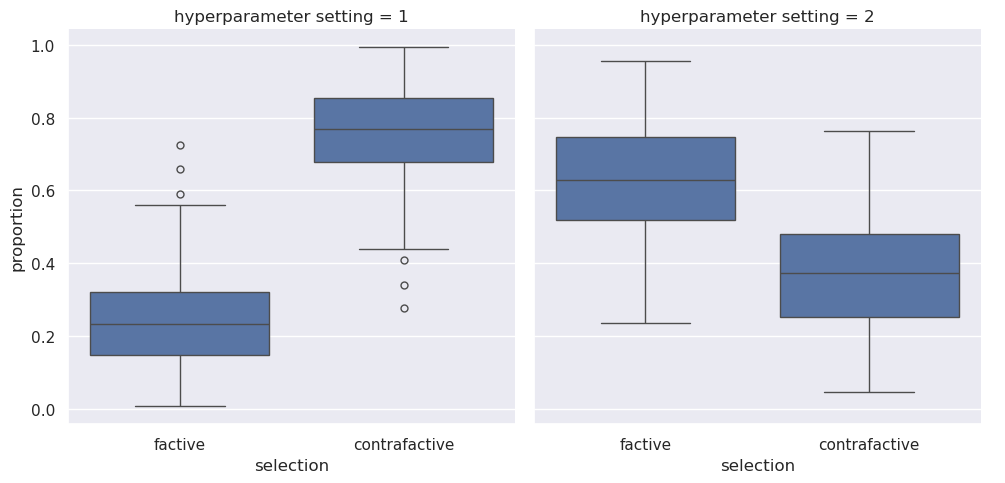

In [47]:
 sns.catplot(
        data=converged_overlap_df,
        x="selection",
        y="proportion",
        order=["factive", "contrafactive"],
        col="hyperparameter setting",
        kind="box",
    )

In [48]:
converged_overlap_df

,options,seed,batch,sample size,selection,proportion,batch size,hyperparameter setting
10,factive-contrafactive,445741,3160,758400,contrafactive,0.343094,240.0,2
42,factive-contrafactive,445741,3320,796800,contrafactive,0.326544,240.0,2
46,factive-contrafactive,445741,3460,830400,contrafactive,0.183959,240.0,2
86,factive-contrafactive,445741,3220,772800,contrafactive,0.396563,240.0,2
118,factive-contrafactive,445741,3360,806400,contrafactive,0.343730,240.0,2
...,...,...,...,...,...,...,...,...
24062,factive-contrafactive,1403899,3500,420000,factive,0.359644,120.0,1
24078,factive-contrafactive,1403899,3600,432000,factive,0.166773,120.0,1
24102,factive-contrafactive,1403899,4280,513600,factive,0.482495,120.0,1
24106,factive-contrafactive,1403899,4300,516000,factive,0.040102,120.0,1


In [49]:
converged_overlap_df[(converged_overlap_df.seed==445741) & (converged_overlap_df.batch < 3100)]

,options,seed,batch,sample size,selection,proportion,batch size,hyperparameter setting
122,factive-contrafactive,445741,3000,720000,contrafactive,0.405474,240.0,2
174,factive-contrafactive,445741,3080,739200,contrafactive,0.485678,240.0,2
402,factive-contrafactive,445741,3040,729600,contrafactive,0.211330,240.0,2
518,factive-contrafactive,445741,3020,724800,contrafactive,0.304901,240.0,2
602,factive-contrafactive,445741,3060,734400,contrafactive,0.154679,240.0,2
8162,factive-contrafactive,445741,3000,720000,non-factive,0.000000,240.0,2
8214,factive-contrafactive,445741,3080,739200,non-factive,0.000000,240.0,2
8442,factive-contrafactive,445741,3040,729600,non-factive,0.000000,240.0,2
8558,factive-contrafactive,445741,3020,724800,non-factive,0.000000,240.0,2
8642,factive-contrafactive,445741,3060,734400,non-factive,0.000000,240.0,2


In [50]:
selection_description_df = converged_overlap_df[converged_overlap_df.selection != "non-factive"].groupby(["hyperparameter setting", "selection"]).proportion.describe()

In [51]:
def format_finer(content: str | int | float) -> str:
    if isinstance(content, int):
        return str(content)
    elif isinstance(content, float):
        return "{:.2f}".format(content)
    elif isinstance(content, str):
        return content
    else:
        print("Warning, using backup")
        return str(content)


print(df_to_latex(selection_description_df, formatter=format_finer))

\begin{tabular}{llrrrrrrrr}
\toprule
 &  & count & mean & std & min & 25\% & 50\% & 75\% & max \\
\midrule
1 & contrafactive & 345.00 & 0.76 & 0.13 & 0.28 & 0.68 & 0.77 & 0.85 & 0.99 \\
 & factive & 345.00 & 0.24 & 0.13 & 0.01 & 0.15 & 0.23 & 0.32 & 0.72 \\
2 & contrafactive & 165.00 & 0.37 & 0.15 & 0.05 & 0.25 & 0.37 & 0.48 & 0.76 \\
 & factive & 165.00 & 0.63 & 0.15 & 0.24 & 0.52 & 0.63 & 0.75 & 0.95 \\
\bottomrule
\end{tabular}

